In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import pandas as pd

# Read the CSV file into a DataFrame
file_path = './data.csv' 
data = pd.read_csv(file_path)

# Define the target column (the value we want to predict)
target_column = 'Adj Close'

# Drop unnecessary columns and select the features
X = data.drop(columns=['Adj Close', 'Date', 'Open', 'Close', 'Low', 'High']) 

# Define the target variable (y)
y = data[target_column]

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the input data using MinMaxScaler (scaling values between 0 and 1)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform on training data
X_test = scaler.transform(X_test)  # Only transform on test data

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)  # Target should be single-dimensional
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create TensorDataset objects for DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader for training and testing sets (with batch size of 32)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [15]:
import torch.nn as nn

# Define a simple neural network class
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        # Initialize the parent class (nn.Module)
        super(NeuralNetwork, self).__init__()

        # Define the layers of the neural network
        self.fc1 = nn.Linear(input_size, 64)  # First fully connected layer (input to 64 neurons)
        self.fc2 = nn.Linear(64, 32)          # Second fully connected layer (64 to 32 neurons)
        self.fc3 = nn.Linear(32, 1)           # Third fully connected layer (32 to 1 output neuron)
        
        # Define the ReLU activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Define the forward pass through the network
        x = self.relu(self.fc1(x))  # Apply ReLU activation after the first layer
        x = self.relu(self.fc2(x))  # Apply ReLU activation after the second layer
        x = self.fc3(x)             # Output layer (no activation function here)
        return x

# Initialize the model with the input size based on the training data
input_size = X_train.shape[1]  # Number of features in the input data
model = NeuralNetwork(input_size)  # Create an instance of the model


In [16]:
import torch.optim as optim

# Define the loss function (Mean Squared Error)
criterion = nn.MSELoss()  # MSE (Mean Squared Error) is commonly used for regression tasks

# Define the optimizer (Adam) with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer adapts learning rates for each parameter


In [17]:
epochs = 100  # Set the number of epochs (iterations over the entire dataset)

# Loop over the number of epochs
for epoch in range(epochs):
    model.train()  # Set the model to training mode (turns on behaviors like dropout)
    running_loss = 0.0  # Initialize the running loss for the epoch
    
    # Loop over batches in the training data
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Reset gradients to zero before each backward pass
        
        outputs = model(inputs)  # Perform forward pass (feed input through the model)
        
        loss = criterion(outputs, targets)  # Calculate the loss (difference between predicted and true values)
        
        loss.backward()  # Perform backpropagation to compute the gradients
        
        optimizer.step()  # Update model parameters using the computed gradients
        
        running_loss += loss.item()  # Add the current loss to the running total

    # Print the average loss for the current epoch
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/100, Loss: 15934.7370
Epoch 2/100, Loss: 9939.1252
Epoch 3/100, Loss: 1080.3157
Epoch 4/100, Loss: 300.9082
Epoch 5/100, Loss: 256.2364
Epoch 6/100, Loss: 208.9844
Epoch 7/100, Loss: 160.7899
Epoch 8/100, Loss: 120.1695
Epoch 9/100, Loss: 91.3451
Epoch 10/100, Loss: 74.3083
Epoch 11/100, Loss: 63.8670
Epoch 12/100, Loss: 58.2433
Epoch 13/100, Loss: 54.2662
Epoch 14/100, Loss: 51.9547
Epoch 15/100, Loss: 49.8976
Epoch 16/100, Loss: 48.0349
Epoch 17/100, Loss: 46.6547
Epoch 18/100, Loss: 44.9440
Epoch 19/100, Loss: 43.7651
Epoch 20/100, Loss: 42.3362
Epoch 21/100, Loss: 41.3554
Epoch 22/100, Loss: 40.0290
Epoch 23/100, Loss: 38.9407
Epoch 24/100, Loss: 38.1650
Epoch 25/100, Loss: 36.9977
Epoch 26/100, Loss: 36.2638
Epoch 27/100, Loss: 35.3170
Epoch 28/100, Loss: 34.2386
Epoch 29/100, Loss: 33.7745
Epoch 30/100, Loss: 32.9897
Epoch 31/100, Loss: 31.7594
Epoch 32/100, Loss: 31.2683
Epoch 33/100, Loss: 30.4430
Epoch 34/100, Loss: 29.7119
Epoch 35/100, Loss: 28.7830
Epoch 36/100, Los

In [18]:
model.eval()  # Set the model to evaluation mode (disables behaviors like dropout)

test_loss = 0.0  # Initialize the test loss

# Disable gradient calculations to save memory and computation (since we are not training)
with torch.no_grad():  # Context manager to turn off gradient tracking
    # Loop over batches in the test data
    for inputs, targets in test_loader:
        outputs = model(inputs)  # Perform forward pass (feed input through the model)
        
        loss = criterion(outputs, targets)  # Calculate the loss (difference between predicted and true values)
        
        test_loss += loss.item()  # Add the current loss to the test loss total

# Print the average test loss
print(f"Test Loss: {test_loss/len(test_loader):.4f}")


Test Loss: 10.7358


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Get the model's predictions on the test set
model.eval()  # Set the model to evaluation mode
predictions = []  # List to store predicted values
actuals = []  # List to store actual values (targets)

# Disable gradient calculations as we are in evaluation mode
with torch.no_grad():
    # Loop over batches in the test data
    for inputs, targets in test_loader:
        outputs = model(inputs)  # Perform forward pass to get predictions
        predictions.extend(outputs.numpy())  # Add the predicted values to the list
        actuals.extend(targets.numpy())  # Add the true values to the list

# Convert predictions and actuals to numpy arrays and squeeze to remove unnecessary dimensions
predictions = np.array(predictions).squeeze()  # Remove extra dimensions if the array is 1D
actuals = np.array(actuals).squeeze()

# Mean Squared Error (MSE) - Measures the average squared difference between predicted and actual values
mse = mean_squared_error(actuals, predictions)

# Root Mean Squared Error (RMSE) - The square root of MSE, interpretable in the same units as the target
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE) - Measures the average of the absolute differences between predicted and actual values
mae = mean_absolute_error(actuals, predictions)

# R2 Score - A measure of how well the predictions match the actual data (higher is better)
r2 = r2_score(actuals, predictions)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R2 Score: {r2:.4f}")


Mean Squared Error (MSE): 10.7485
Root Mean Squared Error (RMSE): 3.2785
Mean Absolute Error (MAE): 2.6197
R2 Score: 0.9655


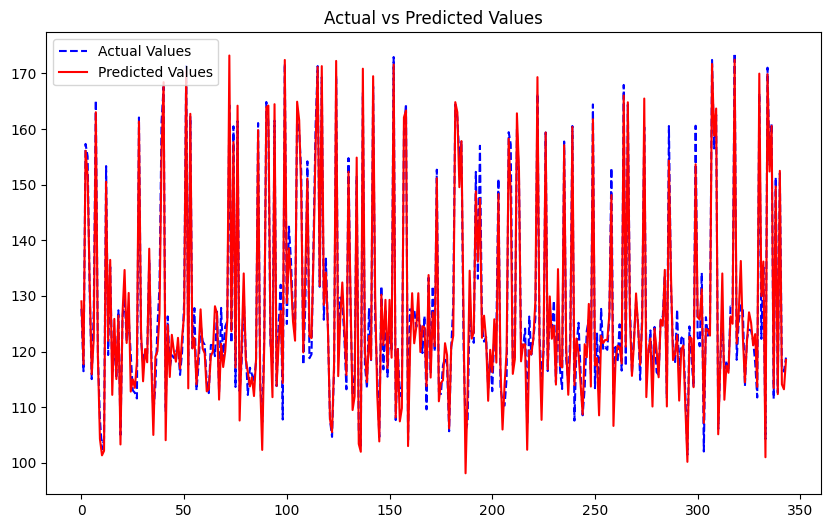

In [20]:
import matplotlib.pyplot as plt

# Actual values (y_test) and predicted values (predictions)
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(y_test.values, label="Actual Values", color='blue', linestyle='dashed')  # Plot actual values in blue with dashed line
plt.plot(predictions, label="Predicted Values", color='red')  # Plot predicted values in red

# Set the title and legend for the plot
plt.title("Actual vs Predicted Values")
plt.legend()  # Display the legend for labels

# Display the plot
plt.show()


C:\Users\gulse\AppData\Local\Temp\ipykernel_13104\3718505987.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'k--', color="orange", lw=2)  # Orange dashed line representing perfect prediction (y=x)


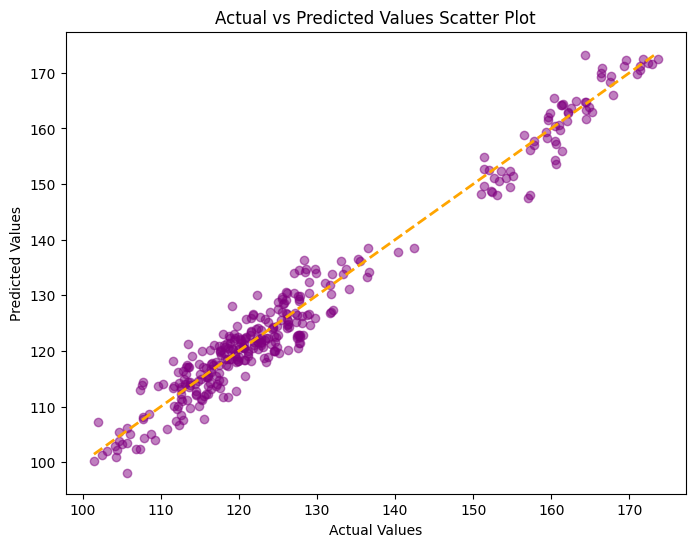

In [21]:
plt.figure(figsize=(8, 6))  # Set the figure size
plt.scatter(actuals, predictions, alpha=0.5, color='purple')  # Scatter plot of actual vs predicted values with purple color and transparency

# Set the labels for the x and y axes
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

# Set the title of the plot
plt.title("Actual vs Predicted Values Scatter Plot")

# Plot the line y = x (diagonal line) for reference
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'k--', color="orange", lw=2)  # Orange dashed line representing perfect prediction (y=x)

# Display the plot
plt.show()


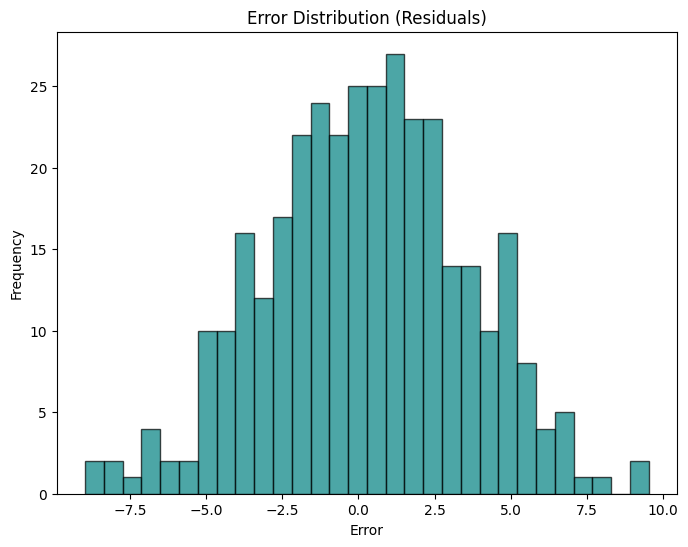

In [22]:
errors = actuals - predictions  # Calculate the errors (Actual - Predicted)

plt.figure(figsize=(8, 6))  # Set the figure size
plt.hist(errors, bins=30, color='teal', edgecolor='black', alpha=0.7)  # Plot the histogram of errors with teal color and black edges

# Set the title and labels for the plot
plt.title("Error Distribution (Residuals)")
plt.xlabel("Error")
plt.ylabel("Frequency")

# Display the plot
plt.show()


Epoch 1/100, Training Loss: 11.4747, Validation Loss: 11.9106
Epoch 2/100, Training Loss: 11.7637, Validation Loss: 11.3484
Epoch 3/100, Training Loss: 11.3156, Validation Loss: 11.0630
Epoch 4/100, Training Loss: 11.2560, Validation Loss: 11.2391
Epoch 5/100, Training Loss: 10.9118, Validation Loss: 10.6849
Epoch 6/100, Training Loss: 11.1431, Validation Loss: 10.8364
Epoch 7/100, Training Loss: 10.9323, Validation Loss: 10.7071
Epoch 8/100, Training Loss: 11.1748, Validation Loss: 10.6250
Epoch 9/100, Training Loss: 10.7887, Validation Loss: 10.5724
Epoch 10/100, Training Loss: 10.7461, Validation Loss: 12.4344
Epoch 11/100, Training Loss: 10.8730, Validation Loss: 10.3484
Epoch 12/100, Training Loss: 10.6763, Validation Loss: 11.1990
Epoch 13/100, Training Loss: 10.6060, Validation Loss: 10.5645
Epoch 14/100, Training Loss: 10.7299, Validation Loss: 10.7145
Epoch 15/100, Training Loss: 10.7647, Validation Loss: 10.2556
Epoch 16/100, Training Loss: 10.6523, Validation Loss: 10.5284
E

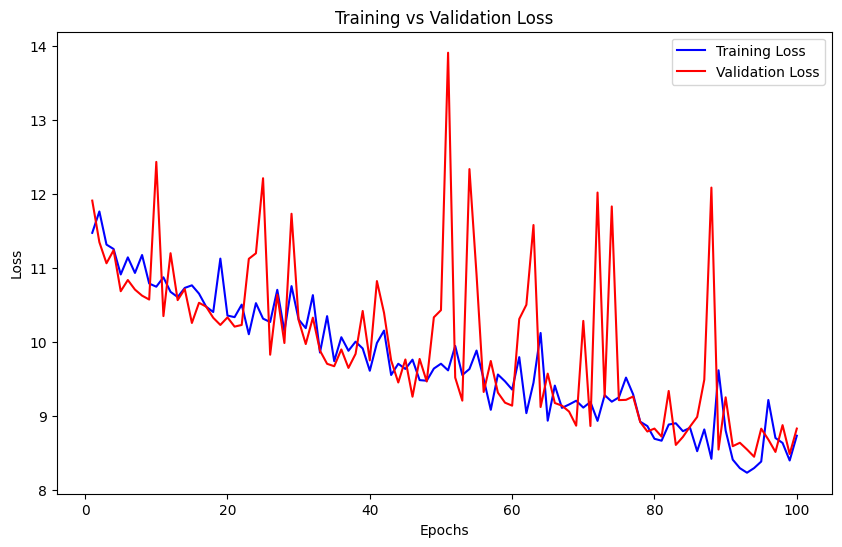

In [23]:
import matplotlib.pyplot as plt

epochs = 100  # Set the number of epochs
train_losses = []  # List to store the training losses
val_losses = []  # List to store the validation losses

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_train_loss = 0.0  # Initialize the training loss

    # Training loop
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Reset gradients to zero before each backward pass
        
        outputs = model(inputs)  # Perform forward pass (feed input through the model)
        
        loss = criterion(outputs, targets)  # Calculate the loss (difference between predicted and true values)
        
        loss.backward()  # Perform backpropagation to compute the gradients
        
        optimizer.step()  # Update model parameters using the computed gradients
        
        running_train_loss += loss.item()  # Add the current loss to the running total for training loss

    # Validation loop (on the test set or validation set)
    model.eval()  # Set the model to evaluation mode (no dropout, no gradient computation)
    running_val_loss = 0.0  # Initialize the validation loss
    
    with torch.no_grad():  # Disable gradient calculation to save memory and computation
        for inputs, targets in test_loader:
            outputs = model(inputs)  # Perform forward pass on the validation set
            loss = criterion(outputs, targets)  # Calculate the validation loss
            running_val_loss += loss.item()  # Add the current validation loss to the running total

    # Calculate the average training and validation losses
    avg_train_loss = running_train_loss / len(train_loader)
    avg_val_loss = running_val_loss / len(test_loader)

    # Append the average losses to the respective lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Print the losses for the current epoch
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", color='blue')
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [24]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

# Switch model to evaluation mode
model.eval()

# Disable gradient computation
with torch.no_grad():
    # Predict on test data
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # Ensure test data is a torch tensor
    y_pred = model(X_test_tensor)  # Forward pass

# Convert predictions to binary classes (example: threshold = 0.5)
threshold = 0.5
y_pred_binary = (y_pred.numpy() >= threshold).astype(int)  # Convert to NumPy array and apply threshold
y_test_binary = (y_test.values >= threshold).astype(int)  # Ensure ground truth is binary

# Calculate metrics
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Precision: 1.0
Recall: 1.0
F1 Score: 1.0
